In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.rcParams['figure.figsize'] = (6,6)
# mpl.rcParams['figure.dpi'] = 100
# mpl.rcParams["image.origin"] = 'lower'

In [167]:
config = {
    "base_dir":        "/storage/vbsjjlnu/VBSjjlnu_v7/",
    "plot_config":     "FullRun2_v7",
    "cut":             "boost_sig",
    "model_version":   "v15",
    "model_tag":       "6l_64n_l2_batchnorm_relu",
    "samples_version": "v1",
    "cols": [
        'Lepton_pt','Lepton_eta',
        'nJets30',
        'vbs_0_pt', 'vbs_1_pt',
        'vjet_0_pt', 'vjet_0_eta',
        'mjj_vbs', 'mjj_vjet',
        'deltaeta_vbs',  'deltaphi_vbs', 
        'Zvjets_0', 'Zlep',
        'Asym_vbs', 'Mtw_lep', 'w_lep_pt', 'w_had_pt',
        'A_ww',
        'Centr_vbs', 'Centr_ww',
        'fatjet_TvsQCD' ,'fatjet_ZvsQCD','fatjet_WvsQCD',
        'fatjet_subjet1_pt','fatjet_subjet2_pt',
        'vbs_0_qgl_boost', 'vbs_1_qgl_boost',
        ],    
    "test_size": 0.10,
    "val_size":  0.0,
    "optimizer": "adam",
    "batch_size": 4096
}

import os

config_base_dir = os.path.join(config["base_dir"], config["plot_config"])

# create the model directory
model_dir   = os.path.join(config_base_dir, config["cut"] , "models",  config["model_version"])
os.makedirs(model_dir, exist_ok=True)

In [109]:
len(config["cols"])

27

```.python
# config examples
"cut":             "boos_sig_mjjincl",
"cut":             "res_sig_mjjincl",
"model_tag":       "res_4depth_v0",
"model_tag":       "boost_5vars_v0",
 ```

In [129]:
# load numpy
samples_dir = os.path.join(config_base_dir, config["cut"] , "samples", config["samples_version"])
import pickle
signal = pickle.load(open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"),     "rb"))
bkg    = pickle.load(open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "rb"))

## Samples preparation for NN

In [22]:
## using 
## source /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/setup.sh
#!pip3 install --user imbalanced-learn==0.5

In [157]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from imblearn.keras import balanced_batch_generator
from imblearn.over_sampling import RandomOverSampler

In [7]:
## instead of reading the variables from file,
## we now set the variables here, and then dump them
# import yaml
# yaml_vars = yaml.safe_load(open(os.path.join(model_dir, "variables.yml")))
# print("yaml: ", type(yaml_vars), len(yaml_vars))
# cols = yaml_vars

In [8]:
bkg.columns[bkg.isnull().any()] 

Index([], dtype='object')

In [158]:
X_sig = signal[config["cols"]].values
X_bkg = bkg[config["cols"]].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values
Wnn_sig = (signal["weight"]).values
Wnn_bkg = (bkg["weight"]).values

In [159]:
X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])
Wnn = np.hstack([Wnn_sig, Wnn_bkg])

In [168]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(f"{model_dir}/scaler_model.pkl", "wb"))

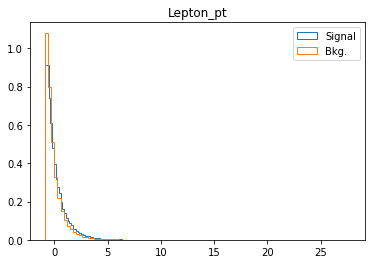

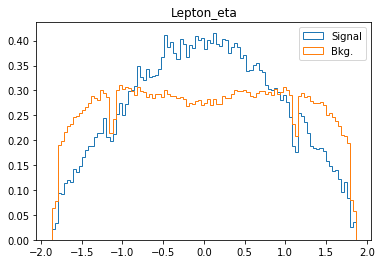

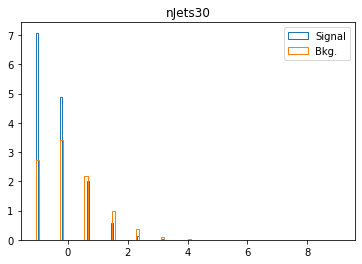

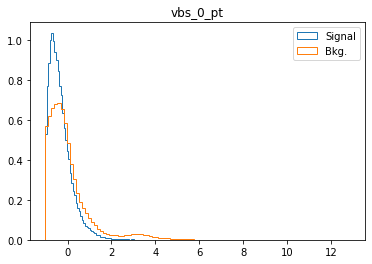

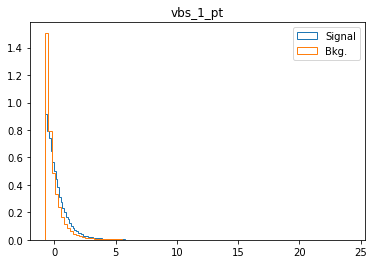

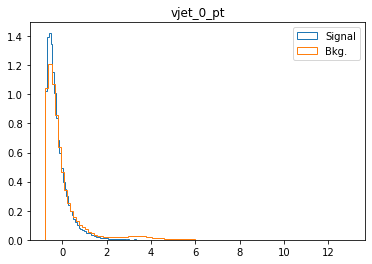

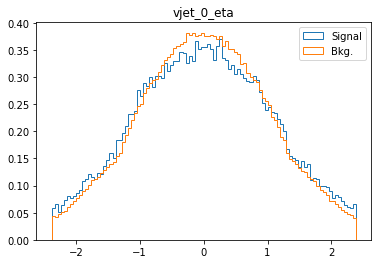

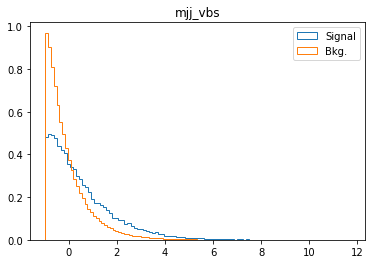

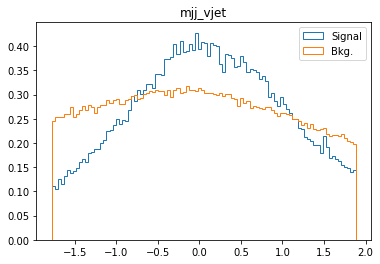

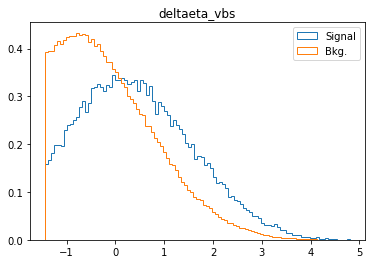

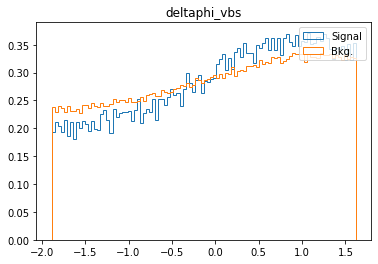

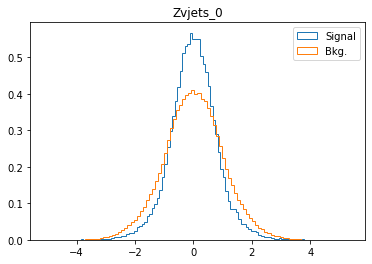

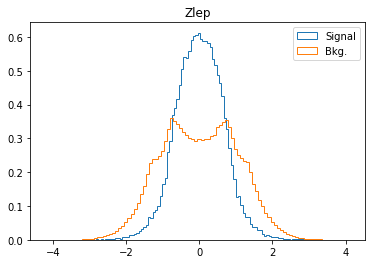

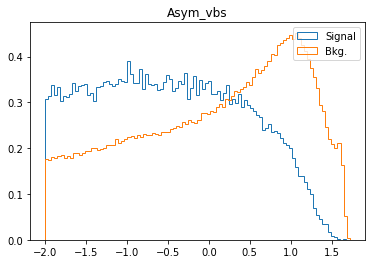

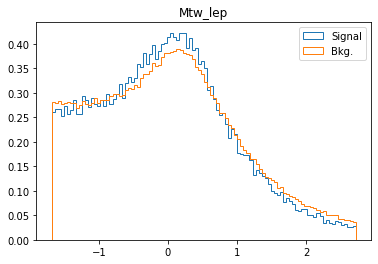

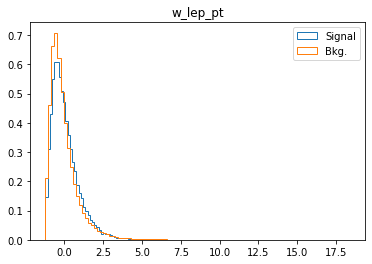

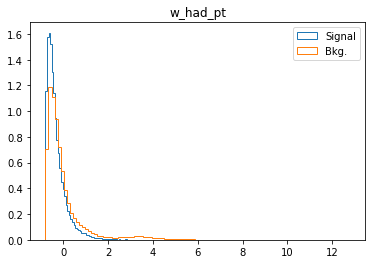

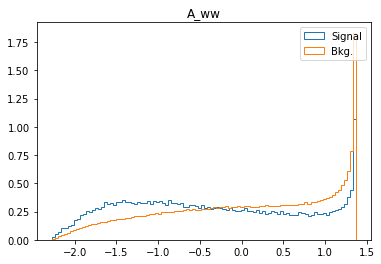

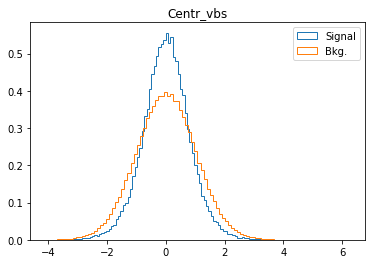

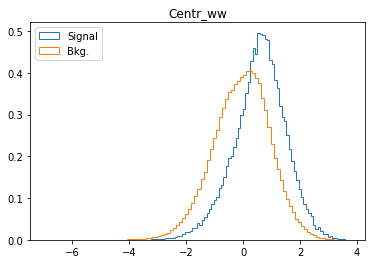

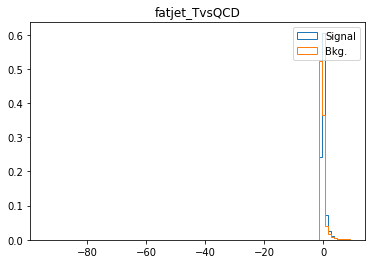

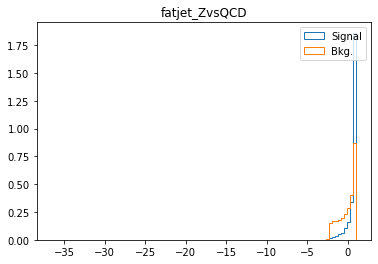

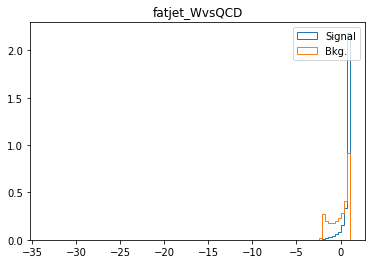

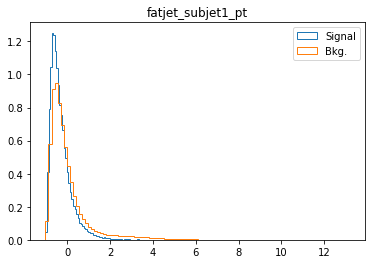

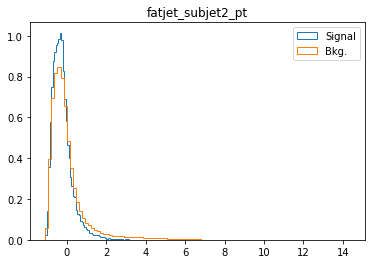

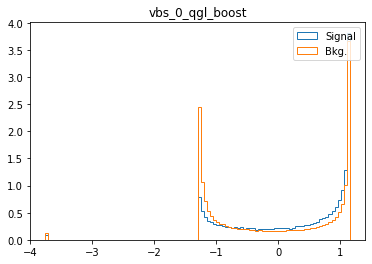

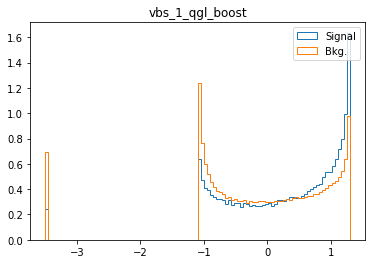

In [161]:
## draw weights and input variables in order to spot any importing error

for idx,col in enumerate(config["cols"]):
    
    _ = plt.hist(X_scaled[Y==1,idx], bins=100, histtype="step", density=True, label="Signal")
    _ = plt.hist(X_scaled[Y==0,idx], bins=100, histtype="step", density=True, label="Bkg.")
    plt.legend()
    plt.title(col)
    plt.show()

##  Balancing


In [169]:
X_train, X_test, y_train, y_test, W_train, W_test , Wnn_train, Wnn_test = \
            train_test_split(X_scaled, Y,  W, Wnn, test_size=config["test_size"], random_state=42, stratify=Y)


#X_val,   X_test, y_val,   y_test, W_val,   W_test = train_test_split(X_temp,   y_temp, W_temp, test_size=config["val_size"]) ## test != val

In [70]:
print("Training   dataset: ", X_train.shape)
print("Test + Val dataset: ", X_test.shape)
#print("Testing    dataset: ", X_test.shape)
#print("Validation dataset: ", X_val.shape)

Training   dataset:  (431327, 27)
Test + Val dataset:  (47926, 27)


Create generators to balance signal and background

## Keras model

In [15]:
%load_ext autoreload


In [16]:
%autoreload 2

In [177]:
# import local module that programmatically returns keras models
import dnn_models_v2

print(config["model_tag"])
model = dnn_models_v2.get_model(config["model_tag"], X_train.shape[1])

model.compile(optimizer=config["optimizer"],
            loss='binary_crossentropy',
            metrics=['accuracy'])

model.summary()

6l_64n_l2_batchnorm_relu
>>> Creating model...
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_115 (Dense)            (None, 64)                1792      
_________________________________________________________________
batch_normalization_64 (Batc (None, 64)                256       
_________________________________________________________________
activation_13 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_116 (Dense)            (None, 64)                4160      
_________________________________________________________________
batch_normalization_65 (Batc (None, 64)                256       
_________________________________________________________________
activation_14 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_

In [178]:
import math
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.96
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    #if lrate < 0.002: return 0.002
    return lrate

In [179]:
## import and configure the plot loss callback

import dnn_plot_loss

data = {
    "X_train": X_train,
    #"X_test" : X_test, ## test != val
    "X_val" : X_test, ## test == val
    "y_train": y_train,
    #"y_test" : y_test, ## test!= val
    "y_val" : y_test, ## test == val
    "W_train": W_train,
    #"W_test" : W_test, ## test != val
    "W_val": W_test, ## test == val
    
    "Wnn_train": Wnn_train,

    #"W_test" : W_test, ## test != val
    "Wnn_val": Wnn_test, ## test == val
}

plot_losses = dnn_plot_loss.PlotLosses(model, data, batch_mode=False)

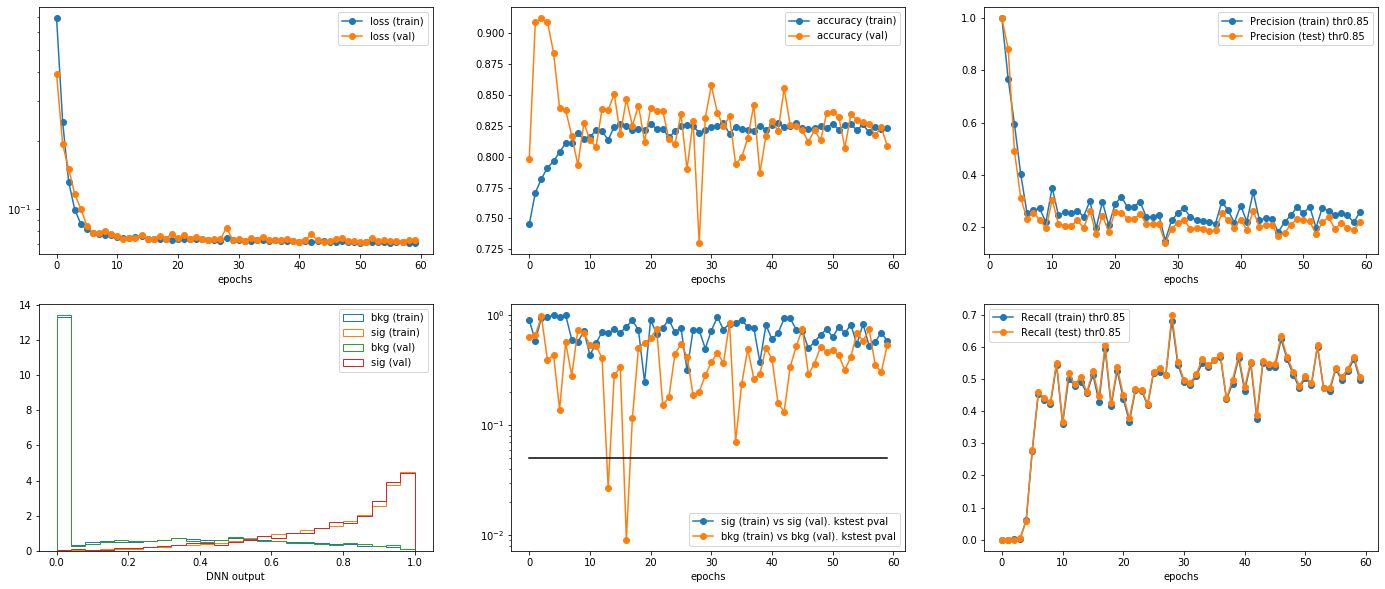

In [180]:
## TRAINING without random sampling

import time
start_time = time.time()
from keras import callbacks

early_stopping = callbacks.EarlyStopping(monitor='val_loss', 
                            min_delta=0.001, patience=30, verbose=0, mode='auto', 
                            baseline=None, restore_best_weights=True)

_callbacks = [plot_losses, early_stopping]

#if config['optimizer'] != "adam":
lr_scheduler = callbacks.LearningRateScheduler(step_decay, verbose=1)
_callbacks.append(lr_scheduler)

config["epochs"] = 60

history = model.fit(
            X_train, y_train,
            sample_weight = W_train,
            epochs=config["epochs"],
            validation_data  = (X_test, y_test, W_test),
            callbacks=_callbacks,
            shuffle = True,
            batch_size= config["batch_size"]
            #callbacks = [], 
            )

config["train_time"] = time.time() - start_time

In [181]:
## SAVE THE MODEL, ITS METADATA AND TRAINING INFORMATIONS

# dump the variables list
import yaml
varfile = os.path.join(model_dir, "variables.yml")
if os.path.isfile(varfile):
    print("ACHTUNG! variables file already existing: old file renamed with '_old'")
    os.rename(varfile, varfile[:-4] + "_old.yml")
with open(varfile, "w") as out_var_file:
    out_var_file.write(yaml.dump(config["cols"]))
    
# dump the config
config["a__model_dir"] = model_dir
model_config_file = os.path.join(model_dir, "model_config.yml")
if os.path.isfile(model_config_file):
    print("ACHTUNG! model_config_file file already existing: old file renamed with '_old'")
    os.rename(model_config_file, model_config_file[:-4] + "_old.yml")
with open(model_config_file, "w") as out_var_file:
    out_var_file.write(yaml.dump(config))  

# save figure with training summary
plot_losses.save_figure( os.path.join(model_dir, "model_train.png") )

# save keras model
model.save( os.path.join(model_dir, "model.h5") )

In [214]:
## Export:
## * keras model to tensorflow model
## * tf metadata
## * scaler

args = {
    "dir": model_dir,
    "input": "model.h5",
    "output": "model.pb",
    "tf_metadata": "tf_metadata.txt",
    "input_scaler": "scaler_model.pkl",
    "output_scaler": "scaler.txt",
}

from keras import backend as K
# This line must be executed before loading Keras model.
K.set_learning_phase(0)

from keras.models import load_model
model = load_model(os.path.join(args["dir"], args["input"]))

from keras import backend as K
import tensorflow as tf

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph


frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

# Save to ./model/tf_model.pb
tf.train.write_graph(frozen_graph, args["dir"], args["output"], as_text=False)

## save tensorflow metadata
with open(os.path.join(args["dir"], args["tf_metadata"]), "w") as f:
    f.write(str(model.inputs[0].name) + " " + str(model.outputs[0].name) + "\n")


## Export 
## * tf tensor input name and output name
## * scaler mean_ and scale_ (where scale_ = np.sqrt(var_)) for each variable
##
import os
import pickle

import yaml
yaml_vars = yaml.safe_load(open(os.path.join(args["dir"], "variables.yml"), "r"))

scaler = pickle.load(open(os.path.join(args["dir"], args["input_scaler"]), 'rb'))
with open(os.path.join(args["dir"], args["output_scaler"]), "w") as f:
    for var, mean, scale in zip(yaml_vars, scaler.mean_, scaler.scale_):
        f.write(var + " " + str(mean) + " " + str(scale) + "\n")


RuntimeError: `get_session` is not available when using TensorFlow 2.0.

In [24]:
## Retrieve graphs history
## plot 
# n = 30
# plt.hist(plot_losses.dnn_score_plot[n][0][1][:-1], bins=plot_losses.dnn_score_plot[n][0][1], weights=plot_losses.dnn_score_plot[n][0][0], histtype="step")
# plt.hist(plot_losses.dnn_score_plot[n][1][1][:-1], bins=plot_losses.dnn_score_plot[n][1][1], weights=plot_losses.dnn_score_plot[n][1][0], histtype="step")

### Columns List

```.python
# resolved
    "cols": ['mjj_vbs', 
             'vbs_0_pt', 
             'vbs_1_pt', 
             'deltaeta_vbs',
             'deltaphi_vbs', 
             'mjj_vjet', 
             'vjet_0_pt', 
             'vjet_1_pt', 
             'vjet_0_eta', 
             'vjet_1_eta', 
             'Lepton_pt', 
             'Lepton_eta', 
             'Lepton_flavour', 
             'PuppiMET', 
             'Zvjets_0', 
             'Zlep', 
             'Asym_vbs', 
             'Asym_vjet', 
             'A_ww', 
             'Mtw_lep', 
             'w_lep_pt', 
             'Mww', 
             'R_ww', 
             'R_mw', 
             'Centr_vbs', 
             'Centr_ww'
         ]

# boosted
    "cols": ['mjj_vbs', 
             'vbs_0_pt', 
             'vbs_1_pt', 
             'deltaeta_vbs',
             'deltaphi_vbs', 
             'mjj_vjet', 
             'vjet_0_pt', 
             'vjet_1_pt', 
             'vjet_0_eta', 
             'vjet_1_eta', 
             'Lepton_pt', 
             'Lepton_eta', 
             'Lepton_flavour', 
             'PuppiMET', 
             'Zvjets_0', 
             'Zlep', 
             'Asym_vbs', 
             'Asym_vjet', 
             'A_ww', 
             'Mtw_lep', 
             'w_lep_pt', 
             'Mww', 
             'R_ww', 
             'R_mw', 
             'Centr_vbs', 
             'Centr_ww'
         ]

         
# OLD
    "cols": ['mjj_vbs', 'deltaeta_vbs', 
            'mjj_vjet', 
            'Lepton_pt', 'Lepton_eta' ]
    "cols": ['mjj_vbs', 
             'vbs_0_pt', 'vbs_1_pt', 
             'deltaeta_vbs', 'deltaphi_vbs', 
             'mjj_vjet', 
             'vjet_0_pt', 'vjet_1_pt', 
             'vjet_0_eta', 'vjet_1_eta', 
             'Lepton_pt', 'Lepton_eta', 'Lepton_flavour', 
         ]
```